In [43]:
from standardInclude import *
enable_atlas_python()

In [63]:
paths = {"EndGame":"/home/jlab/g-2/caloTrackMatching/data/endgame/",
         "Run 2C" :"/home/jlab/g-2/caloTrackMatching/data/run2c/",
         "9-Day" :"/home/jlab/g-2/caloTrackMatching/data/9day/"}

allfiles = {}
for name,path in paths.items():
    print(name,path)
    files = os.listdir(path)
    #print(files)
    names = [x.split("_")[0] for x in files]
    #print(names)

    fs = {}
    for file in files:
        namei = file.split("_")[0]
        fs[namei] = r.TFile(path+file)
        #fs[namei].ls()
    allfiles[name] = fs
print(allfiles)

EndGame /home/jlab/g-2/caloTrackMatching/data/endgame/
Run 2C /home/jlab/g-2/caloTrackMatching/data/run2c/
9-Day /home/jlab/g-2/caloTrackMatching/data/9day/
{'EndGame': {'clusters': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root") at 0x55648806a5c0>, 'tracks': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root") at 0x5564855ea250>, 'matchedTracks': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/endgame/matchedTracks_eg.root") at 0x556487d68f70>}, 'Run 2C': {'tracks': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root") at 0x5564880f8440>, 'clusters': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root") at 0x5564848336f0>, 'matchedTracks': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/run2c/matchedTracks_run2c.root") at 0x5564847b2c00>}, '9-Day': {'tracks': <ROOT.TFile object ("/home/jlab/g-2/caloTrackMatching/data/9day/tracks_9da

In [3]:
allFitResults = {}

In [4]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,0.0001,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Now lets generate comparison plots 

### Tracker

In [5]:
tlow = 50
thigh = 300
station = 12
calo = station +1
func_to_use = {"EndGame":1, "Run 2C":1}

#which file to pull the data from
namei = 'tracks'

#which plot within the file to plot
#toplot = "trackerBeamPosRand"
toplot = "trackerCaloPosRand"

In [6]:
fits = {}
for name in paths:
    print("Starting:",name)
    fs = allfiles[name]
    func,paramVec = fitfunc(func_to_use[name], [tlow,thigh],[15,-1,0.001,-0.001]) 
    f = fs[namei]
    f.ls()
    
    h = f.Get(toplot).Clone()
    h.Rebin3D(1,1,1)
    h.GetZaxis().SetRange(h.GetZaxis().FindBin(station),h.GetZaxis().FindBin(station))
    h.GetYaxis().SetRange(h.GetYaxis().FindBin(-50),h.GetYaxis().FindBin(50))
    widthDict = getWidths(h.Project3D("yx"))
    
    fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
    fits[name] = fitresult

Starting: EndGame
Starting: Run 2C
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH2D	trackerDeltaPosition_vs_Time;1	Vertical Drift of Decay Positrons: Difference Between Naive and Full Extrapolation
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/tracks_run2c.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  K

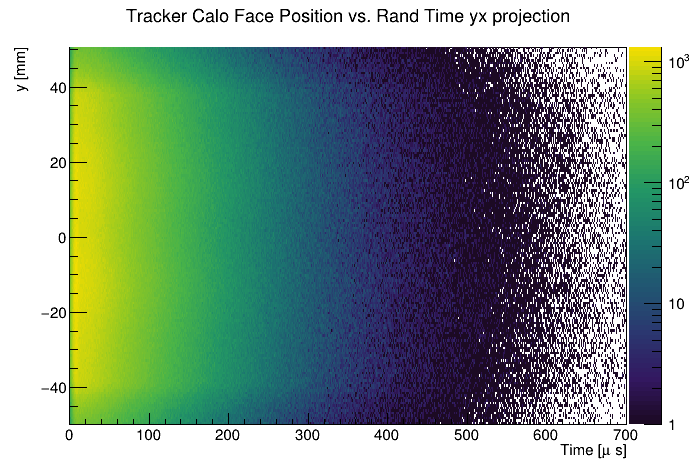

In [7]:
c = r.TCanvas()
h.Project3D("yx").Draw("colz")
c.SetLogz()
c.Draw()

In [8]:
print(fits)

{'EndGame': <python_fit.fitVector object at 0x7f7a3beba150>, 'Run 2C': <python_fit.fitVector object at 0x7f7a3bd28610>}


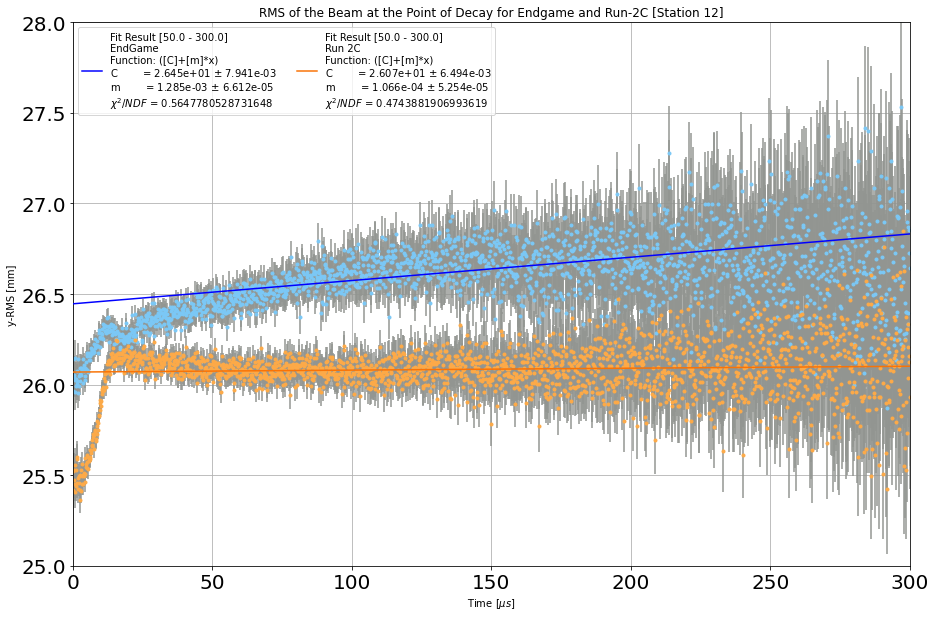

In [9]:
fig,ax = plt.subplots(figsize=(15,10))
fig, ax = compareFits(fits,fig,ax,fmti=".")
plt.ylim(25,28)
#plt.ylim(10,15)
plt.xlim(0,300)
plt.legend(ncol=4,fontsize=10)
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("y-RMS [mm]")
plt.title("RMS of the Beam at the Point of Decay for Endgame and Run-2C [Station "+str(station)+"]")
#plt.title("RMS of the Beam at the Calo Face for Endgame and Run-2C [Station "+str(station)+"]")
plt.show()

---

### Clusters

In [10]:
tlow = 50
thigh = 300
func_to_use = {"EndGame":1, "Run 2C":1}

#which file to pull the data from
namei = 'clusters'

#which plot within the file to plot
#toplot = "trackerBeamPosRand"
toplot = "randclusters"+str(calo)

In [11]:
fits = {}
for name in paths:
    print("Starting:",name)
    fs = allfiles[name]
    func,paramVec = fitfunc(func_to_use[name], [tlow,thigh]) 
    f = fs[namei]
    f.ls()
    
    h = f.Get(toplot).Clone()
    h.GetYaxis().SetRange(h.GetYaxis().FindBin(1000),h.GetYaxis().FindBin(2400))
    h.Rebin3D(10,1,1)
    widthDict = getWidths(h.Project3D("zx"), scale=25, offset=3)
    
    fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
    fits[name] = fitresult

Starting: EndGame
Starting: Run 2C
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters
TFile**		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/run2c/clusters_run2c.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters


In [12]:
print(fits)

{'EndGame': <python_fit.fitVector object at 0x7f7a271b4750>, 'Run 2C': <python_fit.fitVector object at 0x7f7a3b4a06d0>}


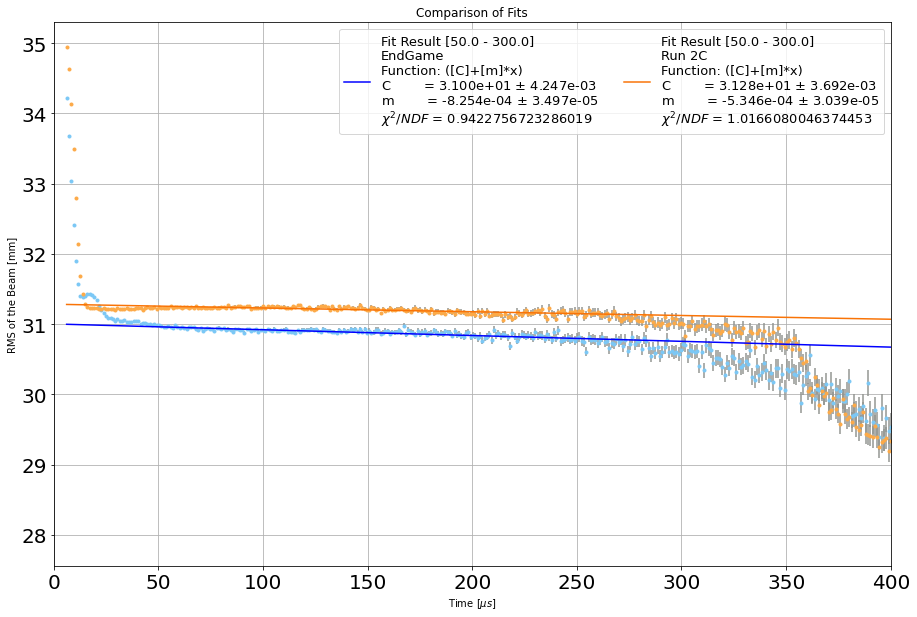

In [13]:
fig,ax = plt.subplots(figsize=(15,10))
fig, ax = compareFits(fits,fig,ax,fmti=".")
#plt.ylim(27,28.5)
plt.xlim(0,400)
plt.legend(ncol=4,fontsize=13)
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("RMS of the Beam [mm]")
plt.show()

---

# Now how about within each dataset

In [14]:
tlow = 25
thigh = 600
func_to_use = {"EndGame":0, "Run 2C":0}

#which file to pull the data from
dataset = "EndGame"
namei = 'tracks'

#which plot within the file to plot
#toplot = "trackerBeamPosRand"
toplot = {"trackerCaloPosRand":0, "randclusters"+str(calo):0}
whichfile={'trackerCaloPosRand':'tracks', "randclusters"+str(calo):'clusters'}

In [15]:
fits = {}
for name in toplot:
    func,paramVec = fitfunc(toplot[name], [tlow,thigh]) 
    fs = allfiles[dataset]
    f = fs[whichfile[name]]
    
    if("trackerCaloPos" in name):
        h = f.Get(name).Clone()
        h.GetZaxis().SetRange(h.GetZaxis().FindBin(station),h.GetZaxis().FindBin(station))
        widthDict = getWidths(h.Project3D("yx"))
    elif("clusters" in name):
        h = f.Get(name).Clone()
        h.GetYaxis().SetRange(h.GetYaxis().FindBin(1000),h.GetYaxis().FindBin(2400))
        widthDict = getWidths(h.Project3D("zx"), scale=25, offset=3)
    else:
        raise ValueError("ERROR: Bahaviour not defined for "+name)
        
    fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
    fits[name] = fitresult

In [16]:
print(fits)

{'trackerCaloPosRand': <python_fit.fitVector object at 0x7f7a3b021e10>, 'randclusters13': <python_fit.fitVector object at 0x7f7a3b01a910>}


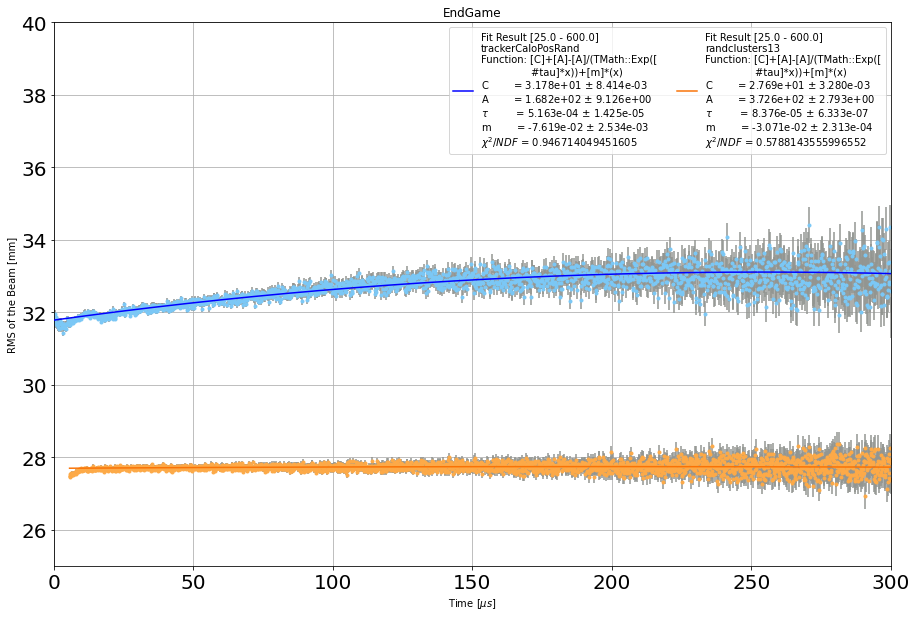

In [17]:
fig,ax = plt.subplots(figsize=(15,10))
fig, ax = compareFits(fits,fig,ax,fmti=".")
plt.ylim(25,40)
plt.xlim(0,300)
plt.legend(ncol=4)
plt.title(dataset)
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("RMS of the Beam [mm]")
plt.show()

---

### Compare random and non-random

In [18]:
tlow = 25
thigh = 600
station = 12
calo = station +1

#which file to pull the data from
dataset = "EndGame"
namei = 'tracks'

#which plot within the file to plot
#toplot = "trackerBeamPosRand"
toplot = {"trackerCaloPos":0, "trackerCaloPosRand":0}

In [19]:
fits = {}
for name in toplot:
    func,paramVec = fitfunc(toplot[name], [tlow,thigh]) 
    fs = allfiles[dataset]
    f = fs[namei]
    
    if("trackerCaloPos" in name):
        h = f.Get(name).Clone()
        h.GetZaxis().SetRange(h.GetZaxis().FindBin(station),h.GetZaxis().FindBin(station))
        h.Rebin3D(1,1,1)
        widthDict = getWidths(h.Project3D("yx"))
    elif("clusters" in name):
        h = f.Get(name).Clone()
        h.GetYaxis().SetRange(h.GetYaxis().FindBin(1000),h.GetYaxis().FindBin(2400))
        widthDict = getWidths(h.Project3D("zx"), scale=25, offset=3)
    else:
        raise ValueError("ERROR: Bahaviour not defined for "+name)
    
        
    fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
    fits[name] = fitresult

In [20]:
print(fits)

{'trackerCaloPos': <python_fit.fitVector object at 0x7f7a27194410>, 'trackerCaloPosRand': <python_fit.fitVector object at 0x7f7a3aa0c050>}


No handles with labels found to put in legend.


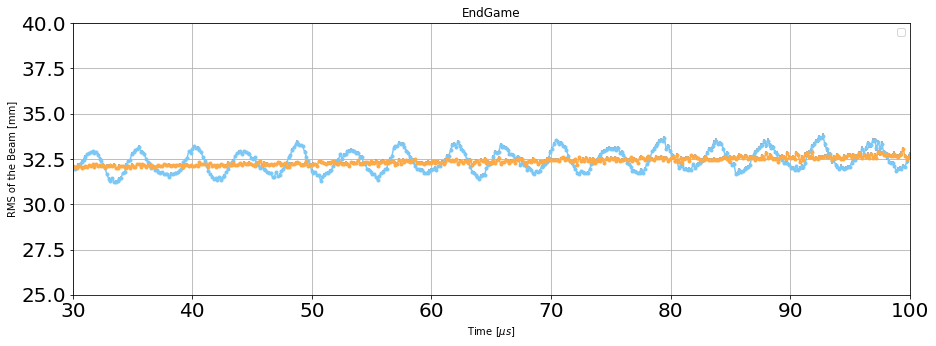

In [21]:
fig,ax = plt.subplots(figsize=(15,5))
fig, ax = compareFits(fits,fig,ax,fmti=".-",drawFits=False)
plt.ylim(25,40)
plt.xlim(30,100)
plt.legend(ncol=4)
plt.title(dataset)
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("RMS of the Beam [mm]")
plt.show()

---

### Full and nieve extrapolation

In [78]:
tlow = 15
thigh = 500
func_to_use = {"EndGame":0, "Run 2C":0, '9-Day':0}
timerebinfactor = 10

#which file to pull the data from
dataset = "9-Day"
namei = 'tracks'

#which plot within the file to plot
#toplot = "trackerBeamPosRand"
toplot = {"trackerCaloPosRand":0,
          "trackerCaloPos_noRadialFieldRand":0}
whichfile={'trackerCaloPosRand':'tracks', "randclusters"+str(calo):'clusters', "trackerCaloPos_noRadialFieldRand":"tracks"}

In [79]:
fits = {}
for name in toplot:
    func,paramVec = fitfunc(toplot[name], [tlow,thigh], [30,-20,0.001,0.001]) 
    fs = allfiles[dataset]
    f = fs[whichfile[name]]
    
    if("trackerCaloPos" in name):
        h = f.Get(name).Clone()
        h.Rebin3D(timerebinfactor,1,1)
        h.GetZaxis().SetRange(h.GetZaxis().FindBin(station),h.GetZaxis().FindBin(station))
        widthDict = getWidths(h.Project3D("yx"))
    elif("clusters" in name):
        h = f.Get(name).Clone()
        h.Rebin3D(timerebinfactor,1,1)
        h.GetYaxis().SetRange(h.GetYaxis().FindBin(1000),h.GetYaxis().FindBin(2400))
        widthDict = getWidths(h.Project3D("zx"), scale=25, offset=3)
    else:
        raise ValueError("ERROR: Bahaviour not defined for "+name)
        
    fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
    fits[name] = fitresult

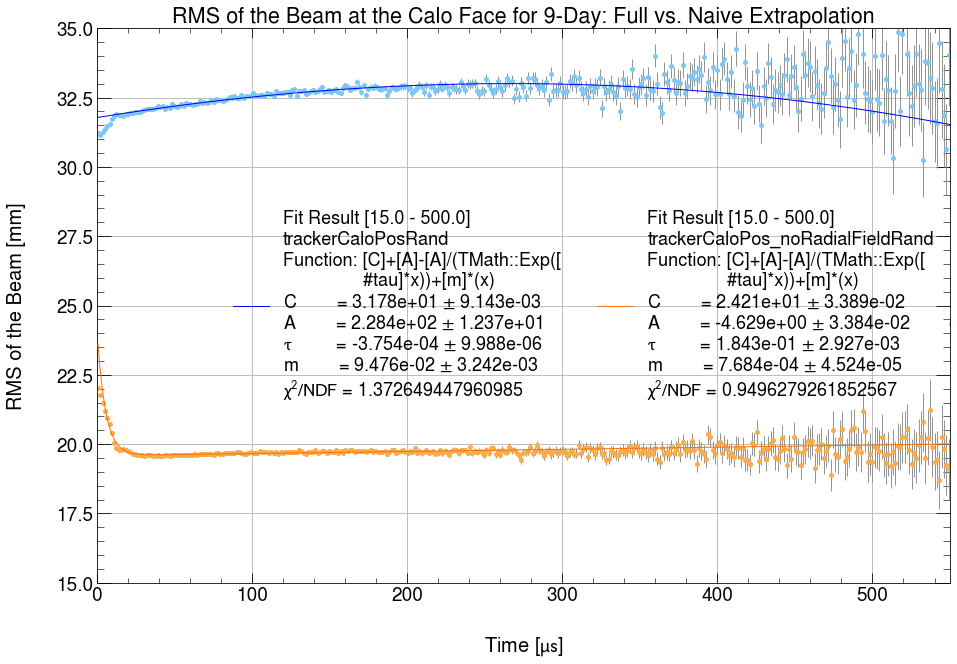

In [80]:
fig,ax = plt.subplots(figsize=(15,10))
fig, ax = compareFits(fits,fig,ax,fmti=".")
plt.ylim(15,35)
plt.xlim(0,550)
plt.legend(ncol=3)
plt.title("RMS of the Beam at the Calo Face for "+dataset+": Full vs. Naive Extrapolation")
plt.xlabel(r"Time [$\mu s$]")
plt.ylabel("RMS of the Beam [mm]")
plt.show()

In [77]:
print(fits)

{'trackerCaloPosRand': <python_fit.fitVector object at 0x7f7a3b4b6290>, 'trackerCaloPos_noRadialFieldRand': <python_fit.fitVector object at 0x7f7a3bd7c3d0>}
